### 10-701 Machine Learning Project
# Image Caption Generation

Team 26  
Olivier Filion  
Michael Agaby  
Nicholas Amano  

All Imports: I'm copy pasting all imports here to stay organized

In [285]:
import sys
print(sys.version)
import json
import os
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

from torchvision.models import googlenet
import torch
import torch.nn as nn
import numpy as np
import tqdm

from torch.utils.data import DataLoader

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


## Utility Functions

In [286]:
import json
import os

def load_captions(path):
    with open(path, "r") as json_file:
        json_dict = json.load(json_file)
    captions = {}
    for annotation in json_dict["annotations"]:
        image_id = annotation["image_id"]
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(annotation["caption"])
    return captions

train_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_train2017.json"))
val_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_val2017.json"))
print(val_captions[139]) 

['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']


In [287]:
from torchtext.data.utils import get_tokenizer

PUNCTUATION = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
PUNCTUATION_TRANS = str.maketrans("", "", PUNCTUATION)

tokenizer = get_tokenizer("basic_english")
def preprocess_captions(captions):
    preprocessed_captions = {}
    for image_id in captions:
        preprocessed_captions[image_id] = []
        for caption in captions[image_id]:
            caption = caption.translate(PUNCTUATION_TRANS)
            caption = "<start> " + caption.lower().strip() + " <end>"
            caption = tokenizer(caption)
            preprocessed_captions[image_id].append(caption)
    return preprocessed_captions

preprocessed_train_captions = preprocess_captions(train_captions)
preprocessed_val_captions = preprocess_captions(val_captions)
print(preprocessed_val_captions[139])

[['<start>', 'a', 'woman', 'stands', 'in', 'the', 'dining', 'area', 'at', 'the', 'table', '<end>'], ['<start>', 'a', 'room', 'with', 'chairs', 'a', 'table', 'and', 'a', 'woman', 'in', 'it', '<end>'], ['<start>', 'a', 'woman', 'standing', 'in', 'a', 'kitchen', 'by', 'a', 'window', '<end>'], ['<start>', 'a', 'person', 'standing', 'at', 'a', 'table', 'in', 'a', 'room', '<end>'], ['<start>', 'a', 'living', 'area', 'with', 'a', 'television', 'and', 'a', 'table', '<end>']]


In [288]:
from torchtext.vocab import build_vocab_from_iterator

def create_vocabulary(tokenized_captions):
    all_tokens = []
    for image_id in tokenized_captions:
        for caption in tokenized_captions[image_id]:
            all_tokens += caption
    return build_vocab_from_iterator([all_tokens], min_freq=1, specials=["<unk>", "<null>"])

vocabulary = create_vocabulary(preprocessed_train_captions)
print(len(vocabulary))

28951


In [293]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize, CenterCrop, Normalize
from functools import lru_cache

# Changed from 256 to 224 for googlenet implementation
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

class CaptionDataset(Dataset):

    def __init__(self, image_folder, preprocessed_captions, vocab, max_caption_length=22):
        self.image_folder = image_folder
        self.captions = preprocessed_captions
        self.vocab = vocab
        self.indices = [(image_id, caption_id)
                        for image_id in preprocessed_captions
                        for caption_id in range(len(preprocessed_captions[image_id]))
                        if len(preprocessed_captions[image_id][caption_id]) <= max_caption_length]
        self.tensor_transform = ToTensor()
        self.scale_transform = Resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        self.crop_transform = CenterCrop((224,224))
        # ******** might not be normalizing Correctly should investigate **********
        self.norm_transform = Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        self.max_caption_length = max_caption_length # includes <start> and <end> tokens, captions shorter than this will be padded with <null> tokens
        # Instantiate CNN model and remove 
        self.CNN = googlenet(pretrained=True)
        self.CNN.fc = nn.Linear(in_features = 1024, out_features= 512)
    
    def __len__(self):
        return len(self.indices)

    @lru_cache(maxsize=128)
    def _get_image(self, image_id, crop_and_scale, convolve):
        image_str = str(image_id)
        image_filename = "0" * (12 - len(image_str)) + image_str + ".jpg"
        image_path = os.path.join(self.image_folder, image_filename)
        image = Image.open(image_path)

        if crop_and_scale:
            image = self.scale_transform(image)
            image = self.crop_transform(image)
            image = self.tensor_transform(image)
            image = self.norm_transform(image)
            if convolve:
                image = self.CNN(image.unsqueeze(0))
            return image
        
        
            
        return self.tensor_transform(image)

    def __getitem__(self, idx, crop_and_scale=True, convolve = True):
        image_id, caption_id = self.indices[idx]
        
        image_tensor = self._get_image(image_id, crop_and_scale, convolve)

        caption = self.captions[image_id][caption_id]
        labels = torch.zeros(self.max_caption_length, 1)
        for i in range(self.max_caption_length):
            token = ("<null>" if i >= len(caption)
                     else caption[i] if caption[i] in self.vocab
                     else "<unk>")
            labels[i][0] = self.vocab[token]
        return image_tensor, labels
  

# Visualizing Some Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([[4.0000e+00],
        [2.0000e+00],
        [3.5600e+02],
        [3.8110e+03],
        [9.0000e+00],
        [2.0000e+00],
        [8.3000e+01],
        [1.2200e+02],
        [7.0000e+00],
        [4.0000e+01],
        [1.0880e+03],
        [3.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00]])
['<start>', 'a', 'bicycle', 'replica', 'with', 'a', 'clock', 'as', 'the', 'front', 'wheel', '<end>']


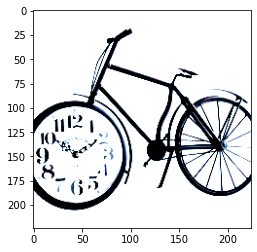

In [294]:
import matplotlib.pyplot as plt

train_ds = CaptionDataset(os.path.join("dataset", "train", "train2017"), preprocessed_train_captions, vocabulary)

im, l = train_ds.__getitem__(0, convolve = False)
print(im.shape)
print(l)
print(preprocessed_train_captions[train_ds.indices[0][0]][train_ds.indices[0][1]])

plt.imshow(im.permute((1, 2, 0)))
plt.show()

In [ ]:
# an example of all 5 captions for one image
im, l = train_ds.__getitem__(10, False)
print(preprocessed_train_captions[train_ds.indices[10][0]][0])
print(preprocessed_train_captions[train_ds.indices[10][0]][1])
print(preprocessed_train_captions[train_ds.indices[10][0]][2])
print(preprocessed_train_captions[train_ds.indices[10][0]][3])
print(preprocessed_train_captions[train_ds.indices[10][0]][4])
plt.imshow(im.permute((1, 2, 0)))
plt.show()

In [ ]:
# 16 images as well as the first few wordsw of one of their captions
plt.subplots(figsize=(16,16))

for i in range(16):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(4,4,i+1)
    plt.title(preprocessed_train_captions[train_ds.indices[5*i][0]][0][1:10], fontsize=8)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

In [ ]:
# first 100 images:
plt.subplots(figsize=(16,16))

for i in range(100):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(10,10,i+1)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

### Aspect Ratios

Estimating the histogram of aspect ratios by random sampling

In [ ]:
from collections import defaultdict
import random

ratios = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[w/h]+=1
plt.hist(ratios, bins='auto') 

### Area

Estimating histogram of area by random sampling


In [291]:
areas = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[h*w]+=1
plt.hist(ratios, bins='auto') 

NameError: name 'random' is not defined

### Finding the most common words 

In [ ]:
counts = defaultdict(int)

for captions in preprocessed_train_captions.values():
    for caption in captions:
        for word in caption:
            counts[word]+=1
        
    

In [ ]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
conjuncts = ['has','small','while','some','down','to','<start>','<end>','a','.','on','of','the','in','with','and', 'is', 'an', 'two', 'one', 'at', 'are', 'next'
            ,'there','side','other','is', 'it', 'that','near', 'the', 'his', 'her', 'they', 'up', 'top', ',', ':', ';', '\''
            ,'by','large','front','back']

for word in conjuncts:
    if(word in sorted_counts):
        sorted_counts.remove(word)
    
print(sorted_counts[0:50])

### Distribution of caption lengths

In [ ]:
import statistics
lengths = []
for captions in preprocessed_train_captions.values():
    for caption in captions:
        lengths.append(len(caption)-2)
        
print("Average caption length: ", sum(lengths)/len(lengths))
print("Median caption length: ", statistics.median(lengths))
print("Shortest caption length: ", min(lengths))
print("Longest caption length: ", max(lengths))
plt.hist(lengths, bins=max(lengths)-min(lengths)) 

We see a clear right skew in the distribution of caption lengths

# Visualizing Activations

In [137]:
from torchvision.models import vgg16 #googlenet, 
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import glob
import torch
import os
from mpl_toolkits.axes_grid1 import ImageGrid
import copy
from torch.autograd import Variable

In [7]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

def get_image(file_path):
    image_path = file_path
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
   
  
    img=transform(image)
    img=img.unsqueeze(0)
    return img

In [8]:
CNN = vgg16(pretrained=True)
CNN.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
convs = [0,2,5,7,10,12,14,17,19,21,24,26,28]

## First conv layer

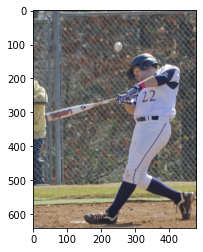

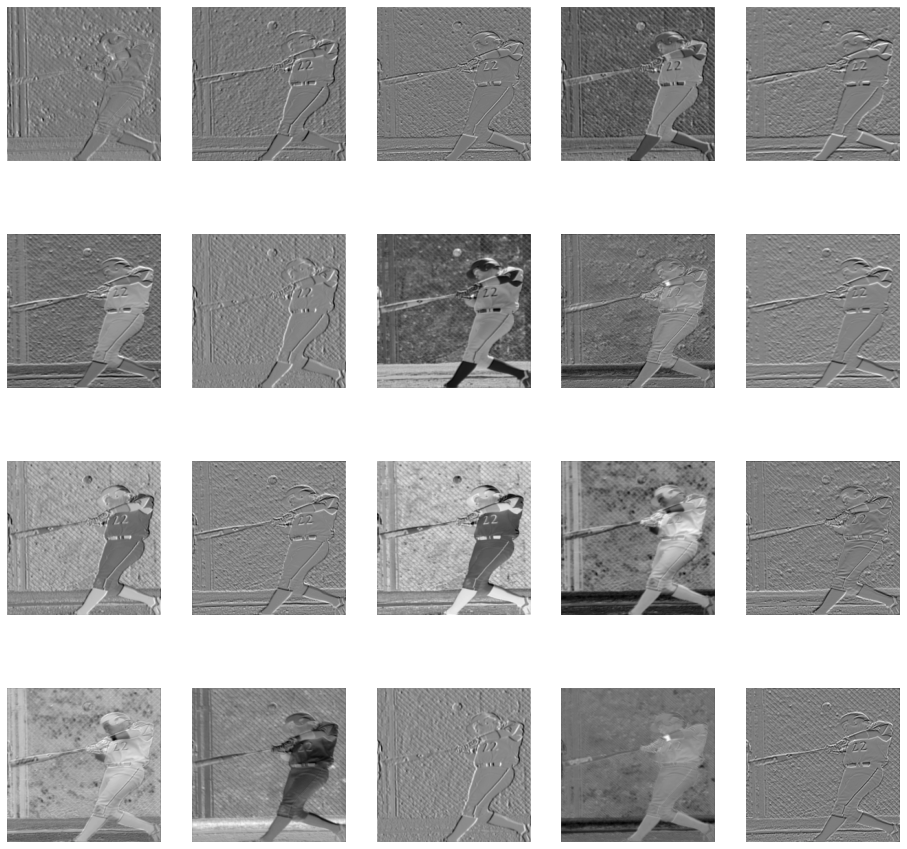

In [60]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
visualize_nth_convolution(CNN, file_path,0)

In [12]:
# visualized after layer #n, has to be aconvolutional layer
def visualize_nth_convolution(model, file_path, layer_num):
    img = get_image(file_path)
    convolved = model.features[0](img)
    for i in range(1, layer_num+1):
        layer = model.features[i]
        convolved = layer(convolved)
        
    plt.subplots(figsize=(16,16))
   
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(convolved[0, :, :, :][i].detach().numpy(), cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()
    

### Second conv layer

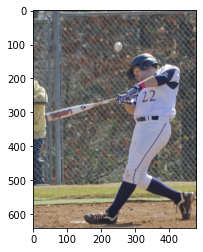

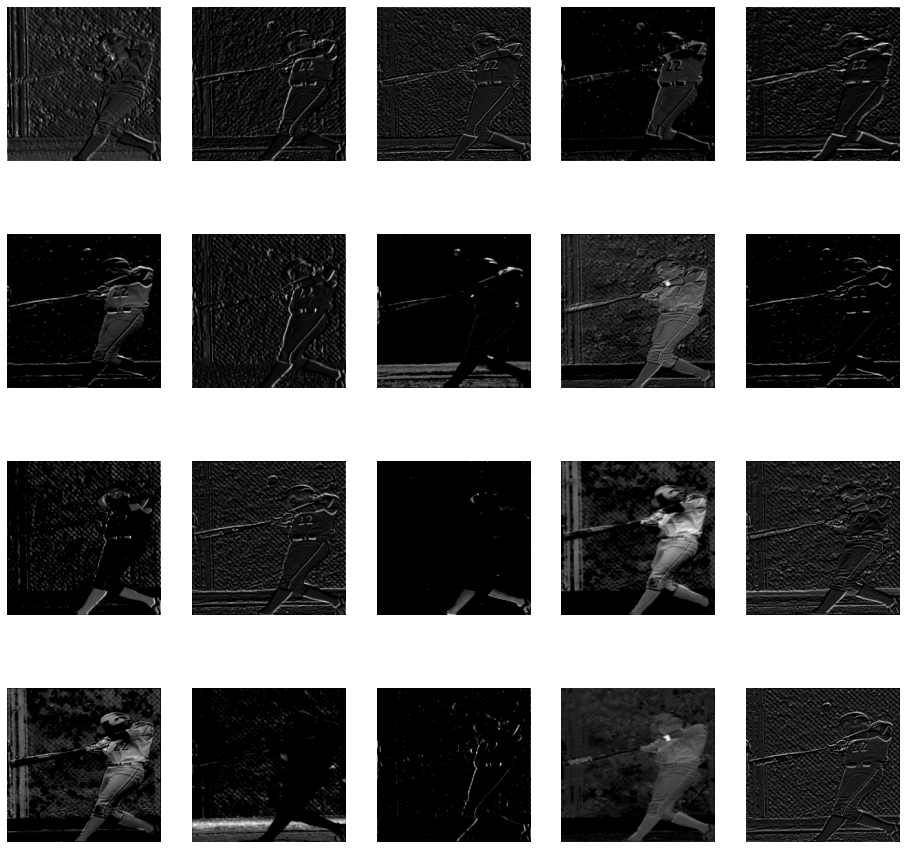

In [61]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
visualize_nth_convolution(CNN, file_path,2)

## Third conv layer

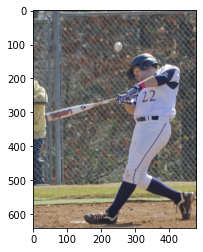

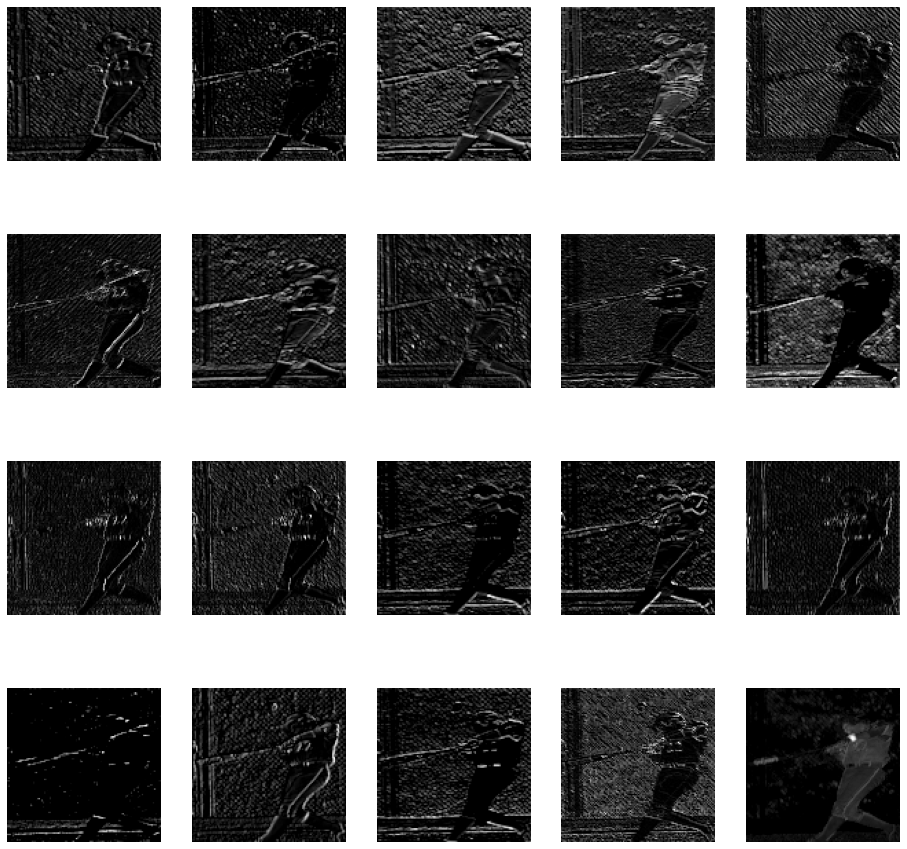

In [62]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
visualize_nth_convolution(CNN, file_path,5)

# Visualizing Convolutions

In [271]:
def activation_maximization(model, layer_num, filter_num):
        
        # initiate a random image
    rand_im = np.uint8(np.random.uniform(0, 255, (224, 224, 3)))
    rand_im = Image.fromarray(rand_im)
        #transform img
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
   
    img=transform(rand_im)
    img = img.unsqueeze(0)
    img_var = Variable(img,requires_grad=True)
        
    optimizer = torch.optim.Adam([img_var], lr=0.05,weight_decay=0.000001)
    
    # 100 iterations
    
    for i in range(100):
        
        optimizer.zero_grad()
            
        temp = img_var
            
            # move forward through the network until the selected layer
        for j in range(layer_num+1):
            layer = model.features[j]
            temp = layer(temp)
            #temp = 2*temp
        
            # get current filter
        output = temp[0, filter_num]
        
        loss = -1*torch.mean(output)
        loss.backward()
            
        optimizer.step()
        
        new_im = copy.copy(img_var.data.numpy()[0])
        
        for channel in range(3):
        
            new_im[channel] /= [1/0.229, 1/0.224, 1/0.225][channel]
            new_im[channel] -= [-0.485, -0.456, -0.406][channel]
        
        new_im[new_im > 1] = 1
        new_im[new_im < 0] = 0
        new_im = np.round(new_im * 255)
        new_im = np.uint8(new_im).transpose(1, 2, 0)
          
    
        #print(img_var)
        
    
    plt.imshow(new_im)
    plt.axis("off")
    plt.show()
        
            
       

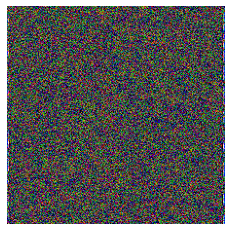

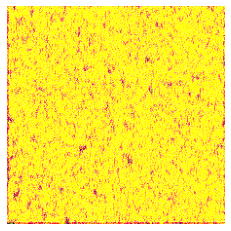

In [277]:
# layer 2, filter 10
activation_maximization(CNN,2,10)
    
# layer 2, filter 20
activation_maximization(CNN,2,20)
    

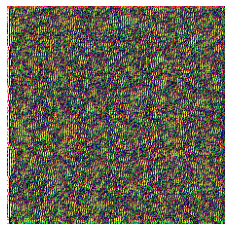

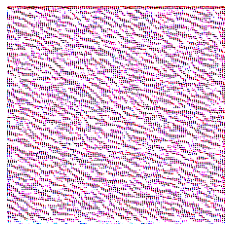

In [278]:
# layer 5, filter 10
activation_maximization(CNN,5,10)
    
# layer 5, filter 20
activation_maximization(CNN,5,20)

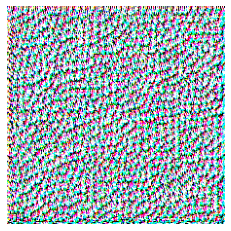

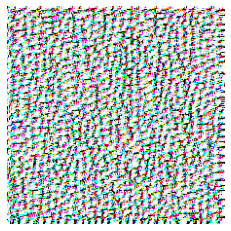

In [279]:
# layer 12, filter 10
activation_maximization(CNN,12,10)
    
# layer 12, filter 20
activation_maximization(CNN,12,20)

In [281]:
def deep_dream(model, layer_num, filter_num, file_path):
    
    img = get_image(file_path)
    img_var = Variable(img,requires_grad=True)
        
    optimizer = torch.optim.Adam([img_var], lr=0.1,weight_decay=0.000001)
 
    for i in range(25):
        
        optimizer.zero_grad()
            
        temp = img_var
            
            # move forward through the network until the selected layer
        for j in range(layer_num+1):
            layer = model.features[j]
            temp = layer(temp)
            #temp = 2*temp
        
            # get current filter
        output = temp[0, filter_num]
        
        loss = -1*torch.mean(output)
        loss.backward()
            
        optimizer.step()
        
        new_im = copy.copy(img_var.data.numpy()[0])
        
        for channel in range(3):
        
            new_im[channel] /= [1/0.229, 1/0.224, 1/0.225][channel]
            new_im[channel] -= [-0.485, -0.456, -0.406][channel]
        
        new_im[new_im > 1] = 1
        new_im[new_im < 0] = 0
        new_im = np.round(new_im * 255)
        new_im = np.uint8(new_im).transpose(1, 2, 0)
          
    
        #print(img_var)
        
    
    plt.imshow(new_im)
    plt.axis("off")
    plt.show()
    
    


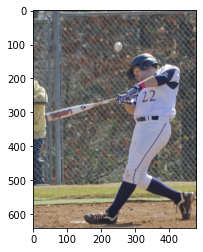

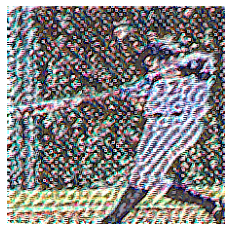

In [283]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
plt.show()
# layer 12, filter 2
deep_dream(CNN, 12, 2, file_path)

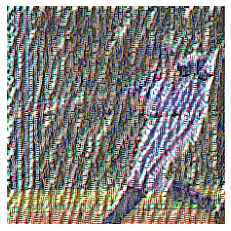

In [284]:
#layer 12, filter 60
deep_dream(CNN, 12, 60, file_path)

# Baseline Model

## Feature extraction
Done uisng a pretrained CNN 

In [6]:
from torchvision.models import googlenet
import torch
import torch.nn as nn
import numpy as np
import tqdm

from torch.utils.data import DataLoader

In [7]:
# Instantiate CNN model** This was placed into the data class**
#CNN = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
CNN = googlenet(pretrained=True)
model = model_class.from_pretrained(pretrained_weights, force_download=True)
CNN.fc = nn.Linear(in_features = 1024, out_features= 512)

RuntimeError: unexpected EOF, expected 321080 more bytes. The file might be corrupted.

## Caption Generations

Using LSTM with one layer and 512 hidden size

In [8]:
decoded_size = hidden_size = 512
vocab_size = len(vocabulary)
num_layers = 2
dropout = .25

In [9]:
# define our model
class Captioner(nn.Module):
    def __init__(self, decoded_size, hidden_size, vocab, max_cap_len,batch_size, num_layers=2, dropout=.25):
        super(Captioner, self).__init__()
        self.input_size = decoded_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.max_cap_len = max_cap_len
        self.batch_size = batch_size
        self.vocab = vocab
        self.vocab_size = len(self.vocab)
        self.dropout = dropout
        
        self.word_embedding = nn.Embedding(vocab_size, decoded_size)
        
        
        self.h0 = torch.zeros(self.num_layers, 1, self.input_size)
        self.c0 = torch.zeros(self.num_layers, 1, self.input_size)
        
        self.lstm = nn.LSTM(input_size  = self.input_size,
                            hidden_size = self.hidden_size, 
                            num_layers = self.num_layers, 
                            dropout =self.dropout)
            
        self.linear = nn.Linear(in_features=self.hidden_size,out_features= self.vocab_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, hn, cn):
        _, (hn, cn) = self.lstm(x, (hn, cn))
        pred = self.softmax(self.linear(hn)[1]).repeat(5,1,1,1)
        return  pred, hn, cn 
    
def train_one_batch(model, optimizer, celoss, x, y, batch_size):
    optimizer.zero_grad()
    predictions = []
    for i in range(batch_size):
        predictions.append(["<start>"])
        
    
    loss_counter = 0
    
    # Assuming batch size = 1
    with torch.no_grad():
        encoded_input = x.detach()
        _, hn,cn = model(encoded_input, model.h0, model.c0)

    encoded_input = model.word_embedding(torch.tensor(4)).repeat(batch_size,1,1)
    
    
    for t in range(model.max_cap_len - 1):
        # take one step of the lstm
        output, hn,cn = model(encoded_input, hn, cn)
        word_encode = torch.argmax(output,axis = 3)
        encoded_input = model.word_embedding(word_encode)
        for index, encoding in enumerate(word_encode):
            next_word = vocabulary.lookup_token(encoding)
            predictions[index].append(next_word)
        # Add to total agg loss
        indicies = torch.index_select(y, 1, torch.tensor([t+1])).squeeze(1).squeeze(1)
        celoss_val = celoss(output.squeeze(1).squeeze(1), indicies.type(torch.LongTensor))
        loss_counter += celoss_val.item()
        celoss_val.backward(retain_graph=True)
        encoded_input = encoded_input.squeeze(1)
    optimizer.step()

        # if next_word == "<end>":
        #     break
        
    return predictions, loss_counter

def train_one_epoch(model, optimizer, loss, batch_size, dataloader):
    losses = []
    predictions = []
    for batch_ds in dataloader:
        pred, step_loss = train_one_batch(model, optimizer, loss, batch_ds[0], batch_ds[1],5 )
        predictions.append(pred)
        losses.append(step_loss)
        print(step_loss)


def train(dataloader, num_epochs,batch_size, decoded_size, hidden_size, vocab, caption_len):
    Model = Captioner(decoded_size, hidden_size, vocabulary, caption_len, batch_size)
    optimizer = torch.optim.Adam(Model.parameters())
    loss = nn.CrossEntropyLoss()
    for i in range(num_epochs):
        print(f"epoch num: {i+1}")
        train_one_epoch(Model, optimizer, loss, batch_size, dataloader)


In [10]:
loader = DataLoader(train_ds, batch_size=5)
train(loader, 50, 5, decoded_size, hidden_size, vocab = vocabulary, 
      caption_len= train_ds.max_caption_length)

epoch num: 1
215.74069023132324


KeyboardInterrupt: 

#### Problems:
1. Mean-std normalize not working
2. Padding